Object detection in autonomous driving is essential for identifying and classifying objects like vehicles, pedestrians, and obstacles to ensure safe navigation. The KITTI dataset is a popular benchmark for this task, providing annotated data from real-world driving scenarios. It includes 8 object classes:

* Car
* Van
* Truck
* Pedestrian
* Sitting Person
* Cyclist
* Tram
* Miscellaneous

[Dataset](https://www.kaggle.com/datasets/klemenko/kitti-dataset)


installing ultralytics to import Yolov8

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.1/875.1 kB 49.8 MB/s eta 0:00:00


# Dataset

In [ ]:
!kaggle datasets download -d klemenko/kitti-dataset

Dataset URL: https://www.kaggle.com/datasets/klemenko/kitti-dataset
License(s): other
100% 22.5G/22.5G [20:37<00:00, 22.3MB/s]
100% 22.5G/22.5G [20:37<00:00, 19.5MB/s]


In [ ]:
!unzip kitti-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: data_object_label_2/training/label_2/002481.txt  
  inflating: data_object_label_2/training/label_2/002482.txt  
  inflating: data_object_label_2/training/label_2/002483.txt  
  inflating: data_object_label_2/training/label_2/002484.txt  
  inflating: data_object_label_2/training/label_2/002485.txt  
  inflating: data_object_label_2/training/label_2/002486.txt  
  inflating: data_object_label_2/training/label_2/002487.txt  
  inflating: data_object_label_2/training/label_2/002488.txt  
  inflating: data_object_label_2/training/label_2/002489.txt  
  inflating: data_object_label_2/training/label_2/002490.txt  
  inflating: data_object_label_2/training/label_2/002491.txt  
  inflating: data_object_label_2/training/label_2/002492.txt  
  inflating: data_object_label_2/training/label_2/002493.txt  
  inflating: data_object_label_2/training/label_2/002494.txt  
  inflating: data_object_label_2/training/label_2/002495.txt  
  in

let's import the needed libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import shutil
from PIL import Image
import torch
from torchvision import transforms
import random
import os
import cv2
from google.colab import files
from ultralytics import YOLO

# PreProcessing

establishing the basic paths for the images and labels

In [ ]:
dir = Path('/content/')
img_path = dir / "data_object_image_2" / "training" / "image_2"
label_path = dir / "data_object_label_2"/"training"/"label_2"

to structre the folder as
* 00000.png
* 00000.txt
* 00001.png
* 00001.txt
....

In [ ]:
ims = sorted(list(img_path.glob('*')))
labels = sorted(list(label_path.glob('*')))
img_labels = list(zip(ims,labels))

to split the data to

80% training

20% validation

In [ ]:
train, valid = train_test_split(img_labels,test_size=0.2,shuffle=True, random_state=42,)
len(train), len(valid)

(5984, 1497)

## Augemntation

applying data augemntation to 20% of the training data

In [ ]:

augmentation = transforms.Compose([
    transforms.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5))
])

# Select 20% of the train images for augmentation
num_images_to_augment = int(len(train) * 0.2)
images_to_augment = random.sample(train, num_images_to_augment)

# Apply augmentation to the 20% of train images
for img_path, label_path in train:
    img = Image.open(img_path)

    # If the image is in the selected 20%, apply augmentation
    if (img_path, label_path) in images_to_augment:
        img = augmentation(img)

Creating train folder, and Validation folder

In [ ]:
train_path = Path('train').resolve()
train_path.mkdir(exist_ok=True)
valid_path = Path('valid').resolve()
valid_path.mkdir(exist_ok=True)

moving the training images and labels to the train folder

In [ ]:
for t_img, t_lb in tqdm(train):
    im_path = train_path / t_img.name
    lb_path = train_path / t_lb.name
    shutil.copy(t_img,im_path)
    shutil.copy(t_lb,lb_path)

  0%|          | 0/5984 [00:00<?, ?it/s]

moving the validation images and labels to the Validation folder

In [ ]:
for t_img, t_lb in tqdm(valid):
    im_path = valid_path / t_img.name
    lb_path = valid_path / t_lb.name
    shutil.copy(t_img,im_path)
    shutil.copy(t_lb,lb_path)

  0%|          | 0/1497 [00:00<?, ?it/s]

In [ ]:
# class mapping
classes = {'Car': 0,
 'Pedestrian': 1,
 'Van': 2,
 'Cyclist': 3,
 'Truck': 4,
 'Misc': 5,
 'Tram': 6,
 'Person_sitting': 7}

creating the needed yaml file for Yolov8

In [ ]:
yaml_file = 'names:\n'
yaml_file += '\n'.join(f'- {c}' for c in classes)
yaml_file += f'\nnc: {len(classes)}'
yaml_file += f'\ntrain: {str(train_path)}\nval: {str(valid_path)}'
with open('kitti2.yaml','w') as f:
    f.write(yaml_file)

to convert the labels from string to numerical value

i.e. car would be 0

In [ ]:
# Function to convert labels {car -> 0}
def convert_labels(label_path):
    with open(label_path, 'r') as file:
        lines = file.readlines()

    new_labels = []
    for line in lines:
        parts = line.split()
        class_name = parts[0]

        # Ignore 'DontCare' class
        if class_name == 'DontCare':
            continue

        bbox = parts[1:]

        # Convert class name to class ID
        try:
            class_id = classes[class_name]
        except KeyError:
            print(f"Class '{class_name}' not found in class_mapping.")
            continue

        # Create new label in YOLO format
        new_label = f"{class_id} {' '.join(bbox)}\n"
        new_labels.append(new_label)

    # Overwrite the label file with the new format
    with open(label_path, 'w') as file:
        file.writelines(new_labels)

# Apply the conversion to all label files
label_dir = '/content/train'  # train
for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):
        convert_labels(os.path.join(label_dir, label_file))
label_dir = '/content/valid'  # valid
for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):
        convert_labels(os.path.join(label_dir, label_file))


the labels files are not in the format that YOLOv8 expects them to be, so we need to normalize it and make it like this:

classlabel xvalue yvalue widthbbox heightbbox


note: it should be normalized between 0 and 1

In [ ]:
# Function to normalize bounding box coordinates for YOLO
def convert_to_yolo(image_width, image_height, xmin, ymin, xmax, ymax):
    x_center = (xmin + xmax) / 2 / image_width # xmin + xmax / 2 = xcenter,  then divide by width to normalize it
    y_center = (ymin + ymax) / 2 / image_height # ymin + ymax / 2 = ycenter,  then divide by height to normalize it
    width_bbox = (xmax - xmin) / image_width
    height_bbox = (ymax - ymin) / image_height
    return x_center, y_center, width_bbox, height_bbox

# Directory paths
label_dir = '/content/train'  # train labels dir
image_dir = '/content/train'  # train imgs dir

for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):
        # Get the corresponding image
        image_file = label_file.replace('.txt', '.png')
        image_path = os.path.join(image_dir, image_file)

        # Check if image exists
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
            image_height, image_width = image.shape[:2]

            # Read label file
            label_path = os.path.join(label_dir, label_file)
            with open(label_path, 'r') as f:
                lines = f.readlines()

            new_labels = []
            for line in lines:
                parts = line.split()
                class_id = parts[0]  # Class ID
                xmin, ymin, xmax, ymax = map(float, parts[4:8])

                # Convert to YOLO format
                x_center, y_center, width_bbox, height_bbox = convert_to_yolo(image_width, image_height, xmin, ymin, xmax, ymax)

                # Ensure coordinates are valid (0 <= x <= 1)
                if 0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 <= width_bbox <= 1 and 0 <= height_bbox <= 1:
                    new_labels.append(f"{class_id} {x_center} {y_center} {width_bbox} {height_bbox}\n")

            # Write the new YOLO-formatted labels back to the file
            with open(label_path, 'w') as f:
                f.writelines(new_labels)

        else:
            print(f"Image {image_path} does not exist, skipping.")




the same process but for the validation data!

In [ ]:

label_dir = '/content/valid'  # valid labels
image_dir = '/content/valid'  # valid images



# Iterate over label files and convert to YOLO format
for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):
        # Get the corresponding image
        image_file = label_file.replace('.txt', '.png')
        image_path = os.path.join(image_dir, image_file)

        # Check if image exists
        if os.path.exists(image_path):
            # Load image to get its dimensions
            image = cv2.imread(image_path)
            image_height, image_width = image.shape[:2]

            # Read label file
            label_path = os.path.join(label_dir, label_file)
            with open(label_path, 'r') as f:
                lines = f.readlines()

            new_labels = []
            for line in lines:
                parts = line.split()
                class_id = parts[0]
                xmin, ymin, xmax, ymax = map(float, parts[4:8])  # Bounding box coordinates

                # Convert to YOLO format
                x_center, y_center, width_bbox, height_bbox = convert_to_yolo(image_width, image_height, xmin, ymin, xmax, ymax)

                # Ensure coordinates are valid (0 <= x <= 1)
                if 0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 <= width_bbox <= 1 and 0 <= height_bbox <= 1:
                    new_labels.append(f"{class_id} {x_center} {y_center} {width_bbox} {height_bbox}\n")

            # Write the new YOLO formatted labels back to the file
            with open(label_path, 'w') as f:
                f.writelines(new_labels)

        else:
            print(f"Image {image_path} does not exist, skipping.")


showcasing an image with its bounding box!

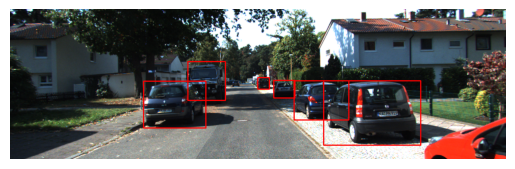

In [ ]:
train_folder = "/content/valid"

# Function to load the image and corresponding label
def show_image_with_bbox(image_path, label_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get image dimensions
    img_height, img_width, _ = img.shape

    # Read the label file
    with open(label_path, 'r') as file:
        labels = file.readlines()

    # Loop over all bounding boxes in the label file
    for label in labels:
        label = label.strip().split()
        class_id = int(label[0])
        x_center, y_center, width, height = map(float, label[1:])

        # Convert from YOLO format to pixel coordinates
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # Calculate the top-left and bottom-right coordinates of the bounding box
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)

        # Draw the bounding box on the image
        img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

    # Display the image with bounding box
    plt.imshow(img)
    plt.axis('off')
    plt.show()
#example
image_file = os.path.join(train_folder, "000031.png")
label_file = os.path.join(train_folder, "000031.txt")

# Show image with bounding box
show_image_with_bbox(image_file, label_file)


# YOLOv8 Model

In [ ]:

model2 = YOLO("yolov8n.pt")

# Train the model
train_results = model2.train(
    data= "/content/kitti2.yaml",
    epochs=200,
    patience=25,
    project='yolov8n-kitti3',
    seed=44,
    optimizer= "Adam",
    lr0=0.0001,
    dropout=0.2

)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 267MB/s]

Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)


engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/kitti2.yaml, epochs=200, time=None, patience=25, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolov8n-kitti3, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=44, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8

100%|██████████| 755k/755k [00:00<00:00, 141MB/s]


Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/train... 5984 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5984/5984 [00:31<00:00, 191.27it/s]


train: New cache created: /content/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/valid... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:07<00:00, 187.38it/s]

val: New cache created: /content/valid.cache


Plotting labels to yolov8n-kitti3/train/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov8n-kitti3/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.49G      1.462      1.658      1.134        153        640: 100%|██████████| 374/374 [00:44<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:07<00:00,  6.11it/s]


                   all       1497       8231      0.526      0.245       0.24      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.28G       1.31      1.186      1.079        209        640: 100%|██████████| 374/374 [00:41<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.65it/s]


                   all       1497       8231      0.532      0.337      0.346      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.33G      1.229      1.045      1.049        181        640: 100%|██████████| 374/374 [00:39<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.42it/s]


                   all       1497       8231      0.566      0.423      0.429      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.52G      1.184     0.9668      1.033        188        640: 100%|██████████| 374/374 [00:39<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.81it/s]


                   all       1497       8231      0.467      0.474      0.463      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200       2.4G      1.154     0.9227      1.023        210        640: 100%|██████████| 374/374 [00:39<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.22it/s]


                   all       1497       8231      0.576      0.502      0.512      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.33G      1.131     0.8792      1.014        206        640: 100%|██████████| 374/374 [00:39<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.01it/s]


                   all       1497       8231      0.594      0.519       0.55      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.42G      1.121     0.8491      1.007        150        640: 100%|██████████| 374/374 [00:39<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.09it/s]


                   all       1497       8231      0.585      0.558      0.588      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.29G      1.097     0.8257      1.002        190        640: 100%|██████████| 374/374 [00:39<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.98it/s]


                   all       1497       8231      0.639      0.561      0.612      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200       2.4G       1.09     0.8087     0.9989        175        640: 100%|██████████| 374/374 [00:39<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.35it/s]

                   all       1497       8231      0.629      0.586       0.62      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200       2.3G      1.071     0.7855     0.9933        177        640: 100%|██████████| 374/374 [00:38<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.84it/s]


                   all       1497       8231      0.718      0.583      0.646      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.43G       1.07     0.7769     0.9901        150        640: 100%|██████████| 374/374 [00:39<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.62it/s]


                   all       1497       8231      0.674      0.591      0.661      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200       2.3G      1.055     0.7609     0.9869        172        640: 100%|██████████| 374/374 [00:39<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.87it/s]

                   all       1497       8231      0.732      0.614      0.678      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200       2.4G      1.045     0.7434      0.981        153        640: 100%|██████████| 374/374 [00:40<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.66it/s]


                   all       1497       8231      0.676      0.641      0.681      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.31G      1.034     0.7341      0.979        164        640: 100%|██████████| 374/374 [00:39<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.87it/s]

                   all       1497       8231      0.754        0.6      0.691      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.33G      1.027     0.7239      0.976        180        640: 100%|██████████| 374/374 [00:39<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.87it/s]

                   all       1497       8231      0.778      0.638      0.706      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.27G      1.022     0.7179      0.974        138        640: 100%|██████████| 374/374 [00:39<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.59it/s]

                   all       1497       8231      0.762      0.636      0.726      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.29G      1.018     0.7115     0.9725        161        640: 100%|██████████| 374/374 [00:40<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.92it/s]


                   all       1497       8231      0.781      0.646       0.73      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.37G      1.007     0.6973     0.9683        157        640: 100%|██████████| 374/374 [00:39<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.51it/s]

                   all       1497       8231      0.765      0.661      0.734      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      2.43G      1.001     0.6924     0.9684        159        640: 100%|██████████| 374/374 [00:40<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.72it/s]

                   all       1497       8231      0.816      0.621      0.742      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.38G     0.9985      0.691     0.9656        261        640: 100%|██████████| 374/374 [00:40<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.44it/s]

                   all       1497       8231      0.819      0.632      0.751      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.29G     0.9851     0.6806     0.9623        176        640: 100%|██████████| 374/374 [00:40<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.88it/s]


                   all       1497       8231      0.813      0.653      0.749      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.25G     0.9826     0.6749     0.9611        167        640: 100%|██████████| 374/374 [00:40<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.12it/s]

                   all       1497       8231      0.789      0.679      0.761      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.49G     0.9809     0.6719     0.9605        213        640: 100%|██████████| 374/374 [00:39<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.92it/s]

                   all       1497       8231      0.805      0.687      0.756      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.31G     0.9684     0.6604     0.9533        172        640: 100%|██████████| 374/374 [00:40<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.24it/s]

                   all       1497       8231      0.806      0.693       0.76      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.33G     0.9704     0.6543     0.9556        195        640: 100%|██████████| 374/374 [00:39<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.80it/s]

                   all       1497       8231      0.821       0.67      0.777       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.33G     0.9658     0.6551     0.9542        183        640: 100%|██████████| 374/374 [00:39<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.56it/s]

                   all       1497       8231      0.799      0.692      0.777      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.31G     0.9604      0.648      0.954        155        640: 100%|██████████| 374/374 [00:39<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.89it/s]

                   all       1497       8231      0.853      0.672      0.783      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.36G      0.957     0.6439     0.9488        198        640: 100%|██████████| 374/374 [00:40<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.34it/s]

                   all       1497       8231      0.809      0.698      0.786      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.33G     0.9477     0.6376     0.9466        153        640: 100%|██████████| 374/374 [00:40<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.80it/s]

                   all       1497       8231      0.783      0.716      0.782       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.54G     0.9412     0.6362      0.947        202        640: 100%|██████████| 374/374 [00:39<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.30it/s]

                   all       1497       8231      0.807      0.709      0.792       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.31G     0.9461     0.6358     0.9464        157        640: 100%|██████████| 374/374 [00:39<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.49it/s]


                   all       1497       8231      0.861      0.692      0.802      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      2.34G     0.9407     0.6304     0.9445        166        640: 100%|██████████| 374/374 [00:39<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.54it/s]


                   all       1497       8231      0.831      0.692      0.788      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.61G     0.9344     0.6255     0.9425        157        640: 100%|██████████| 374/374 [00:39<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.99it/s]

                   all       1497       8231      0.813      0.716      0.795      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200       2.3G     0.9273     0.6217     0.9408        148        640: 100%|██████████| 374/374 [00:39<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.57it/s]


                   all       1497       8231      0.794      0.722      0.801      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      2.41G     0.9263     0.6194     0.9414        177        640: 100%|██████████| 374/374 [00:40<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.86it/s]

                   all       1497       8231      0.843      0.718      0.813      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.61G     0.9239     0.6139     0.9395        182        640: 100%|██████████| 374/374 [00:40<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.57it/s]


                   all       1497       8231        0.8      0.722      0.805      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.51G     0.9236     0.6114     0.9373        202        640: 100%|██████████| 374/374 [00:40<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.84it/s]

                   all       1497       8231      0.804      0.739      0.809      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200       2.4G     0.9184     0.6065     0.9372        184        640: 100%|██████████| 374/374 [00:40<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.59it/s]

                   all       1497       8231      0.824      0.739      0.813      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.28G     0.9136     0.6039     0.9368        146        640: 100%|██████████| 374/374 [00:40<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.88it/s]

                   all       1497       8231      0.833      0.733      0.814      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.42G     0.9084     0.6019     0.9331        160        640: 100%|██████████| 374/374 [00:39<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.65it/s]

                   all       1497       8231      0.817      0.731      0.808      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200       2.4G     0.9105     0.6013     0.9342        202        640: 100%|██████████| 374/374 [00:39<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.69it/s]

                   all       1497       8231      0.866       0.73      0.823      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      2.28G      0.907     0.5975     0.9349        136        640: 100%|██████████| 374/374 [00:39<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.74it/s]

                   all       1497       8231      0.838      0.755      0.824      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      2.32G     0.8975     0.5897     0.9286        170        640: 100%|██████████| 374/374 [00:40<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.70it/s]

                   all       1497       8231      0.836      0.734      0.823      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      2.29G     0.8991      0.592     0.9295        193        640: 100%|██████████| 374/374 [00:39<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.82it/s]

                   all       1497       8231      0.839      0.754      0.828      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.27G     0.8989     0.5899     0.9302        173        640: 100%|██████████| 374/374 [00:39<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.51it/s]

                   all       1497       8231      0.848      0.745      0.829      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.33G     0.8913     0.5846     0.9284        167        640: 100%|██████████| 374/374 [00:40<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.74it/s]

                   all       1497       8231      0.858      0.747      0.829      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.28G     0.8952     0.5878     0.9284        193        640: 100%|██████████| 374/374 [00:40<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.59it/s]

                   all       1497       8231      0.851       0.76      0.843      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.45G     0.8913     0.5813     0.9268        146        640: 100%|██████████| 374/374 [00:39<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.91it/s]

                   all       1497       8231       0.85      0.758      0.835      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      2.29G     0.8859     0.5825     0.9283        115        640: 100%|██████████| 374/374 [00:39<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.39it/s]

                   all       1497       8231      0.858      0.751      0.839      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.34G     0.8817     0.5765     0.9234        161        640: 100%|██████████| 374/374 [00:39<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.99it/s]

                   all       1497       8231      0.884      0.754      0.849       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.38G     0.8827     0.5754     0.9253        170        640: 100%|██████████| 374/374 [00:40<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.45it/s]

                   all       1497       8231      0.849      0.759       0.84      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      2.42G     0.8837     0.5771     0.9242        147        640: 100%|██████████| 374/374 [00:39<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.89it/s]

                   all       1497       8231       0.85      0.758      0.842      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.53G     0.8745     0.5726     0.9226        221        640: 100%|██████████| 374/374 [00:40<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.06it/s]


                   all       1497       8231      0.851      0.759      0.848      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      2.29G     0.8726     0.5653     0.9208        161        640: 100%|██████████| 374/374 [00:39<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.89it/s]

                   all       1497       8231      0.874      0.757      0.844      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      2.35G     0.8696     0.5667     0.9214        140        640: 100%|██████████| 374/374 [00:39<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.61it/s]

                   all       1497       8231      0.848      0.755      0.839      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.29G     0.8648     0.5609     0.9215        191        640: 100%|██████████| 374/374 [00:39<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.95it/s]

                   all       1497       8231      0.852      0.761      0.841      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.43G     0.8643     0.5587     0.9194        186        640: 100%|██████████| 374/374 [00:39<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.10it/s]

                   all       1497       8231      0.845      0.758      0.849      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.29G     0.8624     0.5584     0.9186        123        640: 100%|██████████| 374/374 [00:39<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.76it/s]

                   all       1497       8231      0.861      0.741      0.848      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      2.29G     0.8607      0.558     0.9172        157        640: 100%|██████████| 374/374 [00:39<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.69it/s]


                   all       1497       8231      0.842      0.779      0.857      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      2.41G     0.8625     0.5579     0.9168        207        640: 100%|██████████| 374/374 [00:39<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.95it/s]

                   all       1497       8231      0.847      0.758      0.858      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.23G     0.8588     0.5574     0.9171        196        640: 100%|██████████| 374/374 [00:39<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.83it/s]

                   all       1497       8231      0.846      0.766      0.857      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      2.33G     0.8556     0.5527     0.9163        141        640: 100%|██████████| 374/374 [00:39<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.59it/s]

                   all       1497       8231      0.847      0.786      0.856      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.28G     0.8566     0.5517     0.9159        162        640: 100%|██████████| 374/374 [00:39<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.96it/s]

                   all       1497       8231      0.826      0.802      0.863        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      2.42G     0.8499     0.5511      0.913        187        640: 100%|██████████| 374/374 [00:39<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  6.88it/s]

                   all       1497       8231      0.838      0.794      0.854      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      2.52G     0.8529     0.5502     0.9139        215        640: 100%|██████████| 374/374 [00:39<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.95it/s]

                   all       1497       8231      0.836      0.793      0.862      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.37G     0.8493     0.5449     0.9132        175        640: 100%|██████████| 374/374 [00:39<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.15it/s]

                   all       1497       8231      0.855      0.789      0.865      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      2.38G     0.8436     0.5434     0.9115        227        640: 100%|██████████| 374/374 [00:39<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.91it/s]

                   all       1497       8231      0.849      0.777       0.86      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.41G     0.8482     0.5453      0.911        146        640: 100%|██████████| 374/374 [00:39<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.46it/s]

                   all       1497       8231      0.856      0.766      0.859      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      2.29G       0.84     0.5413       0.91        193        640: 100%|██████████| 374/374 [00:39<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.09it/s]

                   all       1497       8231      0.856      0.773      0.866      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      2.32G     0.8482     0.5439     0.9114        202        640: 100%|██████████| 374/374 [00:39<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.75it/s]

                   all       1497       8231      0.834      0.803      0.868      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      2.61G     0.8395     0.5394     0.9101        186        640: 100%|██████████| 374/374 [00:39<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.94it/s]

                   all       1497       8231      0.864      0.797      0.873      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      2.41G     0.8364     0.5376     0.9093        137        640: 100%|██████████| 374/374 [00:39<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.71it/s]

                   all       1497       8231      0.858       0.78      0.867      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      2.33G     0.8416      0.542     0.9112        196        640: 100%|██████████| 374/374 [00:39<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.71it/s]

                   all       1497       8231       0.88      0.783      0.872      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200       2.3G     0.8356     0.5365     0.9079        189        640: 100%|██████████| 374/374 [00:39<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.97it/s]

                   all       1497       8231      0.871      0.778      0.865      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      2.42G     0.8335     0.5354     0.9084        168        640: 100%|██████████| 374/374 [00:40<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.58it/s]

                   all       1497       8231      0.865      0.796      0.869      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200       2.3G     0.8288     0.5293     0.9077        184        640: 100%|██████████| 374/374 [00:39<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.09it/s]

                   all       1497       8231      0.856      0.796      0.868       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      2.35G       0.83     0.5303      0.906        182        640: 100%|██████████| 374/374 [00:39<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.41it/s]

                   all       1497       8231      0.871      0.798      0.867      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      2.47G     0.8264     0.5306     0.9073        114        640: 100%|██████████| 374/374 [00:39<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.08it/s]

                   all       1497       8231      0.875      0.776      0.865      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.38G     0.8292     0.5299     0.9068        160        640: 100%|██████████| 374/374 [00:39<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.39it/s]

                   all       1497       8231      0.839      0.813      0.865      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      2.39G     0.8261     0.5295     0.9043        108        640: 100%|██████████| 374/374 [00:39<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.06it/s]

                   all       1497       8231      0.853      0.792      0.873      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      2.27G     0.8197     0.5237     0.9052        135        640: 100%|██████████| 374/374 [00:39<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.69it/s]

                   all       1497       8231      0.875      0.788      0.872      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.41G     0.8207     0.5263     0.9035        208        640: 100%|██████████| 374/374 [00:39<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.34it/s]

                   all       1497       8231      0.868      0.791      0.869      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      2.33G     0.8251     0.5252     0.9069        136        640: 100%|██████████| 374/374 [00:39<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.81it/s]

                   all       1497       8231       0.87        0.8      0.872      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      2.29G     0.8168     0.5235     0.9022        184        640: 100%|██████████| 374/374 [00:39<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.61it/s]

                   all       1497       8231      0.876      0.785      0.871      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      2.26G     0.8204     0.5248     0.9037        217        640: 100%|██████████| 374/374 [00:39<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.92it/s]

                   all       1497       8231      0.864      0.803      0.869       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      2.54G     0.8133     0.5189     0.9032        164        640: 100%|██████████| 374/374 [00:39<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.45it/s]

                   all       1497       8231      0.868      0.791      0.866      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      2.28G     0.8148     0.5207     0.9033        138        640: 100%|██████████| 374/374 [00:39<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.92it/s]

                   all       1497       8231      0.868      0.786      0.868      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      2.41G     0.8147     0.5173     0.9026        159        640: 100%|██████████| 374/374 [00:39<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.52it/s]

                   all       1497       8231      0.862      0.798      0.866       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      2.51G     0.8138     0.5167     0.9015        147        640: 100%|██████████| 374/374 [00:39<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.95it/s]

                   all       1497       8231      0.861      0.791      0.867      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      2.29G     0.8099     0.5183     0.9017        180        640: 100%|██████████| 374/374 [00:40<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.57it/s]

                   all       1497       8231      0.848      0.817       0.87      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      2.41G     0.8111     0.5166     0.9033        173        640: 100%|██████████| 374/374 [00:39<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.92it/s]

                   all       1497       8231      0.878      0.791      0.874      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200       2.3G     0.8059     0.5134     0.9003        188        640: 100%|██████████| 374/374 [00:39<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.78it/s]

                   all       1497       8231      0.869      0.797      0.873      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      2.23G     0.8063     0.5127     0.9001        205        640: 100%|██████████| 374/374 [00:39<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.55it/s]

                   all       1497       8231      0.876       0.81       0.88      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      2.43G     0.8033     0.5114     0.8992        219        640: 100%|██████████| 374/374 [00:39<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.04it/s]

                   all       1497       8231      0.865      0.821      0.883      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      2.41G     0.8019      0.511     0.8991        155        640: 100%|██████████| 374/374 [00:39<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.63it/s]

                   all       1497       8231      0.859      0.819      0.883       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      2.33G     0.8048     0.5115     0.8966        173        640: 100%|██████████| 374/374 [00:39<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.94it/s]

                   all       1497       8231      0.883      0.808      0.886      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      2.31G     0.8022     0.5103     0.8992        209        640: 100%|██████████| 374/374 [00:39<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.54it/s]

                   all       1497       8231      0.889      0.792      0.883      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      2.41G     0.7957      0.506     0.8969        139        640: 100%|██████████| 374/374 [00:39<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.01it/s]

                   all       1497       8231      0.891      0.796      0.883      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      2.41G     0.8008     0.5089     0.8991        175        640: 100%|██████████| 374/374 [00:39<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.63it/s]

                   all       1497       8231      0.899      0.795      0.887      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      2.27G     0.7943     0.5038     0.8971        167        640: 100%|██████████| 374/374 [00:39<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.79it/s]

                   all       1497       8231      0.899      0.798      0.888      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      2.49G      0.799     0.5046     0.8964        128        640: 100%|██████████| 374/374 [00:39<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.67it/s]

                   all       1497       8231      0.881      0.811      0.887      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      2.44G     0.7995     0.5048     0.8973        182        640: 100%|██████████| 374/374 [00:39<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.66it/s]

                   all       1497       8231      0.895      0.797      0.887      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      2.38G     0.7962     0.5058     0.8963        192        640: 100%|██████████| 374/374 [00:39<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.87it/s]

                   all       1497       8231      0.898      0.797      0.889      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      2.48G      0.795     0.5039     0.8974        209        640: 100%|██████████| 374/374 [00:39<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.52it/s]

                   all       1497       8231      0.874      0.824      0.888      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      2.73G     0.7905     0.5007     0.8939        167        640: 100%|██████████| 374/374 [00:39<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.91it/s]

                   all       1497       8231      0.899      0.803      0.882      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      2.39G     0.7912     0.5012     0.8947        186        640: 100%|██████████| 374/374 [00:39<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.55it/s]

                   all       1497       8231      0.887      0.814      0.885      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      2.31G     0.7895     0.5009     0.8937        206        640: 100%|██████████| 374/374 [00:39<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.00it/s]

                   all       1497       8231       0.89      0.808      0.882      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      2.23G     0.7864     0.4979     0.8955        187        640: 100%|██████████| 374/374 [00:39<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.51it/s]

                   all       1497       8231      0.882      0.809      0.882      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200       2.4G     0.7856     0.4988      0.893        207        640: 100%|██████████| 374/374 [00:39<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.02it/s]

                   all       1497       8231      0.889      0.818      0.887      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      2.29G     0.7865     0.4974     0.8917        198        640: 100%|██████████| 374/374 [00:39<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.73it/s]

                   all       1497       8231      0.881      0.822      0.889      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      2.41G     0.7882      0.499     0.8948        168        640: 100%|██████████| 374/374 [00:40<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.80it/s]

                   all       1497       8231      0.885      0.807      0.886      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200       2.3G     0.7843     0.4958     0.8944        205        640: 100%|██████████| 374/374 [00:39<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.60it/s]

                   all       1497       8231      0.883      0.813      0.887      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.52G      0.782     0.4954     0.8921        169        640: 100%|██████████| 374/374 [00:39<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.82it/s]

                   all       1497       8231      0.876      0.817      0.887      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      2.49G     0.7792      0.494     0.8926        151        640: 100%|██████████| 374/374 [00:39<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.80it/s]

                   all       1497       8231      0.865      0.815      0.883      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      2.33G     0.7829     0.4946     0.8926        176        640: 100%|██████████| 374/374 [00:39<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.77it/s]

                   all       1497       8231      0.885      0.805      0.884       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      2.32G     0.7808     0.4937     0.8927        202        640: 100%|██████████| 374/374 [00:39<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.00it/s]

                   all       1497       8231      0.892      0.809      0.887      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200       2.5G       0.78     0.4923     0.8909        173        640: 100%|██████████| 374/374 [00:39<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.66it/s]

                   all       1497       8231      0.878      0.814      0.888       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200       2.4G     0.7774      0.493     0.8921        180        640: 100%|██████████| 374/374 [00:39<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.01it/s]

                   all       1497       8231      0.895      0.811       0.89      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      2.38G     0.7744     0.4878     0.8907        141        640: 100%|██████████| 374/374 [00:39<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.46it/s]

                   all       1497       8231      0.899      0.806       0.89      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      2.32G     0.7762     0.4886     0.8899        139        640: 100%|██████████| 374/374 [00:39<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.04it/s]

                   all       1497       8231      0.901       0.81       0.89      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      2.43G     0.7709     0.4863     0.8909        211        640: 100%|██████████| 374/374 [00:39<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.72it/s]

                   all       1497       8231      0.893      0.806      0.887      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      2.31G     0.7753     0.4919     0.8908        152        640: 100%|██████████| 374/374 [00:39<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.98it/s]

                   all       1497       8231      0.906      0.802       0.89      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      2.51G     0.7759     0.4898     0.8908        154        640: 100%|██████████| 374/374 [00:39<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.72it/s]

                   all       1497       8231      0.905        0.8      0.889      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      2.41G     0.7708     0.4879     0.8903        241        640: 100%|██████████| 374/374 [00:39<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.83it/s]

                   all       1497       8231      0.857      0.842       0.89      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      2.43G      0.768     0.4841     0.8876        188        640: 100%|██████████| 374/374 [00:39<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.88it/s]

                   all       1497       8231      0.855      0.837      0.887      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200       2.3G     0.7758     0.4886     0.8895        193        640: 100%|██████████| 374/374 [00:39<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.53it/s]

                   all       1497       8231       0.85      0.839      0.887       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      2.33G     0.7709     0.4864     0.8891        200        640: 100%|██████████| 374/374 [00:39<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.88it/s]

                   all       1497       8231      0.859      0.834      0.886      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      2.33G     0.7646     0.4821     0.8872        151        640: 100%|██████████| 374/374 [00:39<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.44it/s]

                   all       1497       8231      0.858      0.832      0.885      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      2.34G     0.7706     0.4859     0.8891        205        640: 100%|██████████| 374/374 [00:39<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.68it/s]

                   all       1497       8231      0.855      0.834      0.887      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      2.38G     0.7653      0.481      0.887        174        640: 100%|██████████| 374/374 [00:39<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.54it/s]

                   all       1497       8231      0.869      0.819      0.886      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200       2.3G     0.7671     0.4841     0.8882        138        640: 100%|██████████| 374/374 [00:39<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.95it/s]

                   all       1497       8231      0.854      0.827      0.884      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      2.41G     0.7618     0.4806     0.8855        191        640: 100%|██████████| 374/374 [00:39<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.60it/s]

                   all       1497       8231      0.854      0.828      0.884       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      2.33G     0.7627     0.4797     0.8859        153        640: 100%|██████████| 374/374 [00:39<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.02it/s]

                   all       1497       8231      0.854      0.834      0.885      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      2.41G     0.7654     0.4828     0.8864        169        640: 100%|██████████| 374/374 [00:39<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.73it/s]

                   all       1497       8231      0.848      0.832      0.885      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200       2.4G      0.759     0.4784     0.8872        195        640: 100%|██████████| 374/374 [00:39<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.51it/s]

                   all       1497       8231      0.864      0.825      0.886      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      2.52G       0.76     0.4779     0.8852        125        640: 100%|██████████| 374/374 [00:39<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.85it/s]

                   all       1497       8231      0.871      0.819      0.885      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      2.42G     0.7589     0.4784      0.886        168        640: 100%|██████████| 374/374 [00:39<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.65it/s]

                   all       1497       8231      0.871       0.82      0.885      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      2.34G     0.7577     0.4753     0.8852        142        640: 100%|██████████| 374/374 [00:39<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.10it/s]

                   all       1497       8231      0.875      0.816      0.887      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      2.51G     0.7574     0.4779     0.8856        183        640: 100%|██████████| 374/374 [00:39<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.54it/s]

                   all       1497       8231      0.868      0.822      0.888      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      2.25G     0.7606     0.4782     0.8863        163        640: 100%|██████████| 374/374 [00:39<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.03it/s]

                   all       1497       8231      0.891      0.799      0.887      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      2.32G     0.7617     0.4794     0.8861        188        640: 100%|██████████| 374/374 [00:39<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.58it/s]

                   all       1497       8231        0.9        0.8      0.889      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      2.33G     0.7565     0.4765     0.8837        170        640: 100%|██████████| 374/374 [00:39<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.90it/s]

                   all       1497       8231      0.889      0.807      0.889      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      2.52G     0.7591     0.4785     0.8854        182        640: 100%|██████████| 374/374 [00:39<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.35it/s]

                   all       1497       8231      0.916      0.782      0.887      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      2.38G     0.7518     0.4737      0.884        237        640: 100%|██████████| 374/374 [00:39<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.95it/s]

                   all       1497       8231        0.9      0.795      0.888      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      2.28G     0.7566     0.4746     0.8856        232        640: 100%|██████████| 374/374 [00:39<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.60it/s]

                   all       1497       8231      0.869      0.819      0.888      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      2.22G     0.7513     0.4727     0.8835        225        640: 100%|██████████| 374/374 [00:39<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.81it/s]

                   all       1497       8231      0.873      0.817      0.889      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      2.32G     0.7555     0.4766     0.8854        200        640: 100%|██████████| 374/374 [00:39<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.87it/s]

                   all       1497       8231       0.87      0.818       0.89      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      2.24G     0.7486     0.4698     0.8825        202        640: 100%|██████████| 374/374 [00:39<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.56it/s]

                   all       1497       8231      0.868       0.82      0.891       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200       2.5G     0.7556      0.474     0.8835        199        640: 100%|██████████| 374/374 [00:39<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.32it/s]

                   all       1497       8231      0.874      0.818       0.89       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      2.44G     0.7514     0.4718      0.882        162        640: 100%|██████████| 374/374 [00:39<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.43it/s]

                   all       1497       8231      0.877      0.824      0.891       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      2.41G     0.7472     0.4707     0.8833        201        640: 100%|██████████| 374/374 [00:39<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.98it/s]

                   all       1497       8231      0.864       0.83      0.891      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      2.39G     0.7465      0.471      0.884        162        640: 100%|██████████| 374/374 [00:39<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.44it/s]

                   all       1497       8231      0.863       0.83      0.891       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200       2.3G     0.7488     0.4716     0.8832        198        640: 100%|██████████| 374/374 [00:39<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.86it/s]

                   all       1497       8231       0.86      0.831      0.891       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      2.42G     0.7435     0.4675     0.8807        175        640: 100%|██████████| 374/374 [00:39<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.78it/s]

                   all       1497       8231      0.865      0.832      0.892      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      2.51G     0.7438     0.4673     0.8814        195        640: 100%|██████████| 374/374 [00:39<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.80it/s]

                   all       1497       8231      0.862      0.834      0.893      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200       2.3G     0.7431     0.4655     0.8807        174        640: 100%|██████████| 374/374 [00:39<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.65it/s]

                   all       1497       8231      0.864      0.834      0.893      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      2.31G     0.7434     0.4674     0.8807        129        640: 100%|██████████| 374/374 [00:39<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.54it/s]

                   all       1497       8231      0.861      0.836      0.894      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      2.31G     0.7463     0.4699     0.8827        180        640: 100%|██████████| 374/374 [00:39<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.77it/s]

                   all       1497       8231      0.862      0.835      0.894      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      2.32G     0.7458     0.4678     0.8807        184        640: 100%|██████████| 374/374 [00:39<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.68it/s]

                   all       1497       8231      0.861      0.839      0.894      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200       2.4G     0.7386     0.4671     0.8811        176        640: 100%|██████████| 374/374 [00:39<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.95it/s]

                   all       1497       8231       0.86       0.84      0.893      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      2.31G     0.7438     0.4645     0.8799        168        640: 100%|██████████| 374/374 [00:39<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.56it/s]

                   all       1497       8231      0.864      0.837      0.893      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      2.33G     0.7368      0.464     0.8791        135        640: 100%|██████████| 374/374 [00:39<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.86it/s]

                   all       1497       8231      0.869      0.824       0.89       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      2.39G     0.7375     0.4624     0.8803        127        640: 100%|██████████| 374/374 [00:39<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.40it/s]

                   all       1497       8231      0.872      0.825      0.892      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      2.27G     0.7419     0.4643     0.8801        183        640: 100%|██████████| 374/374 [00:39<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.93it/s]

                   all       1497       8231       0.87      0.823      0.889       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      2.41G     0.7353     0.4626     0.8779        159        640: 100%|██████████| 374/374 [00:39<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.52it/s]

                   all       1497       8231      0.871      0.823       0.89       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200       2.4G     0.7366     0.4625     0.8787        190        640: 100%|██████████| 374/374 [00:39<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.87it/s]

                   all       1497       8231       0.87      0.822      0.888      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      2.31G      0.734     0.4599     0.8801        179        640: 100%|██████████| 374/374 [00:39<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.57it/s]

                   all       1497       8231      0.876      0.817      0.891      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      2.43G     0.7338     0.4599     0.8779        141        640: 100%|██████████| 374/374 [00:39<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.82it/s]

                   all       1497       8231      0.878      0.816      0.892      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200       2.3G      0.735     0.4599     0.8786        188        640: 100%|██████████| 374/374 [00:39<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.90it/s]

                   all       1497       8231      0.878      0.814      0.889      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      2.51G     0.7326     0.4617     0.8784        189        640: 100%|██████████| 374/374 [00:39<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.61it/s]

                   all       1497       8231      0.882      0.812       0.89      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200       2.4G     0.7385     0.4627     0.8805        152        640: 100%|██████████| 374/374 [00:39<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.04it/s]

                   all       1497       8231      0.882      0.813      0.892      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      2.32G      0.731     0.4614     0.8789        190        640: 100%|██████████| 374/374 [00:39<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.49it/s]

                   all       1497       8231      0.881      0.811      0.889      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      2.26G     0.7348     0.4595     0.8788        255        640: 100%|██████████| 374/374 [00:39<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.88it/s]

                   all       1497       8231      0.883      0.814      0.892      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      2.41G     0.7269     0.4571     0.8781        170        640: 100%|██████████| 374/374 [00:39<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.63it/s]

                   all       1497       8231      0.881      0.814      0.892      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      2.43G      0.728     0.4567     0.8762        108        640: 100%|██████████| 374/374 [00:39<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.97it/s]

                   all       1497       8231      0.882      0.814      0.892      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      2.41G     0.7337     0.4595     0.8786        156        640: 100%|██████████| 374/374 [00:39<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.67it/s]

                   all       1497       8231      0.884      0.814      0.892      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      2.34G     0.7285     0.4571     0.8762        195        640: 100%|██████████| 374/374 [00:39<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.77it/s]

                   all       1497       8231      0.883      0.815      0.892      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      2.38G     0.7347     0.4604     0.8789        155        640: 100%|██████████| 374/374 [00:39<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.61it/s]

                   all       1497       8231      0.892      0.815      0.894      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      2.46G      0.731     0.4594     0.8789        121        640: 100%|██████████| 374/374 [00:39<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.54it/s]

                   all       1497       8231      0.892      0.814      0.894      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      2.51G     0.7306     0.4584     0.8759        221        640: 100%|██████████| 374/374 [00:39<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.90it/s]

                   all       1497       8231      0.892      0.815      0.895      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      2.33G     0.7282     0.4564     0.8765        169        640: 100%|██████████| 374/374 [00:39<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.41it/s]

                   all       1497       8231      0.891      0.815      0.895      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      2.49G     0.7284     0.4569     0.8761        165        640: 100%|██████████| 374/374 [00:39<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.95it/s]

                   all       1497       8231      0.891      0.815      0.895      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      2.38G      0.726      0.455     0.8756        252        640: 100%|██████████| 374/374 [00:39<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.52it/s]

                   all       1497       8231       0.89      0.815      0.895      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      2.34G      0.726     0.4536     0.8774        220        640: 100%|██████████| 374/374 [00:39<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.91it/s]

                   all       1497       8231      0.889      0.815      0.895      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      2.41G     0.7304     0.4564     0.8778        147        640: 100%|██████████| 374/374 [00:39<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.58it/s]

                   all       1497       8231      0.891      0.814      0.895      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      2.34G     0.7265     0.4553     0.8782        157        640: 100%|██████████| 374/374 [00:39<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.68it/s]

                   all       1497       8231      0.889      0.816      0.895      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      2.34G     0.7279     0.4554     0.8764        163        640: 100%|██████████| 374/374 [00:39<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.90it/s]

                   all       1497       8231       0.89      0.815      0.895      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      2.39G     0.7231     0.4531     0.8739        131        640: 100%|██████████| 374/374 [00:39<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.76it/s]

                   all       1497       8231       0.89      0.815      0.895      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      2.32G     0.7274     0.4544     0.8773        241        640: 100%|██████████| 374/374 [00:39<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.97it/s]

                   all       1497       8231      0.892      0.816      0.895      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      2.43G     0.7227     0.4521      0.875        193        640: 100%|██████████| 374/374 [00:39<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.43it/s]

                   all       1497       8231      0.889      0.815      0.895      0.653


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      2.19G     0.7395     0.4468     0.8735        101        640: 100%|██████████| 374/374 [00:39<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.09it/s]

                   all       1497       8231      0.891      0.815      0.895      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      2.13G     0.7127      0.433     0.8669         93        640: 100%|██████████| 374/374 [00:38<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.53it/s]

                   all       1497       8231      0.891      0.815      0.895      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      2.11G     0.7072     0.4299     0.8657         96        640: 100%|██████████| 374/374 [00:38<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.00it/s]

                   all       1497       8231      0.894      0.815      0.895      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      2.11G     0.7033     0.4276     0.8664         92        640: 100%|██████████| 374/374 [00:38<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.74it/s]

                   all       1497       8231      0.891      0.815      0.895      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200       2.1G     0.6965     0.4238     0.8635         86        640: 100%|██████████| 374/374 [00:38<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.56it/s]

                   all       1497       8231      0.896      0.814      0.895      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      2.12G     0.6943     0.4237     0.8634         82        640: 100%|██████████| 374/374 [00:38<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.00it/s]

                   all       1497       8231      0.893      0.814      0.895      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      2.11G     0.6914      0.421     0.8632         64        640: 100%|██████████| 374/374 [00:38<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.51it/s]

                   all       1497       8231      0.895      0.814      0.895      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      2.12G     0.6924     0.4203     0.8614         75        640: 100%|██████████| 374/374 [00:38<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.78it/s]

                   all       1497       8231      0.895      0.813      0.896      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200       2.1G     0.6922     0.4232     0.8633         76        640: 100%|██████████| 374/374 [00:38<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.69it/s]

                   all       1497       8231      0.895      0.813      0.896      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200       2.1G      0.689     0.4193     0.8613         67        640: 100%|██████████| 374/374 [00:38<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:06<00:00,  7.62it/s]

                   all       1497       8231      0.891      0.818      0.896      0.654



200 epochs completed in 2.579 hours.
Optimizer stripped from yolov8n-kitti3/train/weights/last.pt, 6.2MB
Optimizer stripped from yolov8n-kitti3/train/weights/best.pt, 6.2MB

Validating yolov8n-kitti3/train/weights/best.pt...
Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.87it/s]


                   all       1497       8231      0.896      0.813      0.896      0.653
                   Car       1338       5889      0.943      0.906      0.964      0.791
            Pedestrian        359        916      0.933      0.658      0.823      0.488
                   Van        427        570      0.928      0.886      0.955      0.761
               Cyclist        222        308      0.931      0.756      0.882      0.578
                 Truck        220        227      0.973      0.965      0.981      0.824
                  Misc        156        187      0.876      0.791      0.878      0.645
                  Tram         62         95      0.942      0.895      0.966      0.718
        Person_sitting         20         39      0.644      0.649       0.72      0.421
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to yolov8n-kitti3/train


# Results

as we can see after training the model we achieved these results

for all classes we got:
* 89.6% percision
* 81.3% recall
* 89.6% mAP50

the next 2 cells are used to download the project folder to my local machine

In [ ]:

shutil.make_archive('results', 'zip', 'yolov8n-kitti3')


'/content/output2.zip'

In [ ]:

files.download('results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!unzip "/content/results.zip"

Archive:  /content/results.zip
   creating: train/
   creating: train/weights/
  inflating: train/val_batch0_pred.jpg  
  inflating: train/train_batch0.jpg  
  inflating: train/results.csv       
  inflating: train/results.png       
  inflating: train/confusion_matrix.png  
  inflating: train/events.out.tfevents.1727518178.ade036845817.2905.0  
  inflating: train/F1_curve.png      
  inflating: train/R_curve.png       
  inflating: train/P_curve.png       
  inflating: train/confusion_matrix_normalized.png  
  inflating: train/val_batch1_labels.jpg  
  inflating: train/train_batch71061.jpg  
  inflating: train/train_batch71062.jpg  
  inflating: train/PR_curve.png      
  inflating: train/train_batch1.jpg  
  inflating: train/train_batch2.jpg  
  inflating: train/args.yaml         
  inflating: train/labels.jpg        
  inflating: train/val_batch2_pred.jpg  
  inflating: train/val_batch0_labels.jpg  
  inflating: train/val_batch2_labels.jpg  
  inflating: train/labels_correlogram.jpg

 Loading the model and predicting on the test folder we have

In [ ]:
model = YOLO('/content/train/weights/best.pt')
model.predict("/content/data_object_image_2/testing/image_2",save=True)


Streaming output truncated to the last 5000 lines.
image 2521/7518 /content/data_object_image_2/testing/image_2/002520.png: 224x640 1 Car, 1 Van, 1 Truck, 6.3ms
image 2522/7518 /content/data_object_image_2/testing/image_2/002521.png: 224x640 1 Car, 6.1ms
image 2523/7518 /content/data_object_image_2/testing/image_2/002522.png: 224x640 1 Pedestrian, 6.2ms
image 2524/7518 /content/data_object_image_2/testing/image_2/002523.png: 224x640 2 Cars, 6.2ms
image 2525/7518 /content/data_object_image_2/testing/image_2/002524.png: 224x640 3 Cars, 6.5ms
image 2526/7518 /content/data_object_image_2/testing/image_2/002525.png: 224x640 1 Pedestrian, 6.2ms
image 2527/7518 /content/data_object_image_2/testing/image_2/002526.png: 224x640 9 Cars, 6.4ms
image 2528/7518 /content/data_object_image_2/testing/image_2/002527.png: 224x640 3 Cars, 6.1ms
image 2529/7518 /content/data_object_image_2/testing/image_2/002528.png: 224x640 2 Cars, 6.1ms
image 2530/7518 /content/data_object_image_2/testing/image_2/002529.

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Car', 1: 'Pedestrian', 2: 'Van', 3: 'Cyclist', 4: 'Truck', 5: 'Misc', 6: 'Tram', 7: 'Person_sitting'}
 obb: None
 orig_img: array([[[ 71,  56,  40],
         [ 43,  46,  42],
         [ 41,  36,  46],
         ...,
         [  6,   7,   5],
         [  6,   9,   5],
         [  6,  10,   6]],
 
        [[ 46,  52,  40],
         [ 36,  41,  40],
         [ 34,  35,  50],
         ...,
         [  6,   8,   5],
         [  6,   9,   5],
         [  6,   9,   5]],
 
        [[ 45,  48,  36],
         [ 34,  40,  36],
         [ 29,  33,  40],
         ...,
         [  5,   8,   5],
         [  5,   7,   5],
         [  5,   7,   5]],
 
        ...,
 
        [[168, 178, 172],
         [182, 180, 175],
         [189, 184, 177],
         ...,
         [ 20,  19,  21],
         [ 20,  16,  17],
         [ 21,  14,  14]],
 
        [[178, 18

showcasing a predicted image

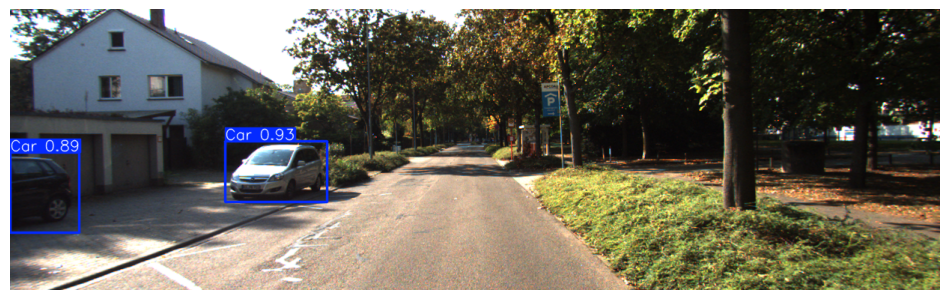

In [ ]:
img = plt.imread("/content/runs/detect/predict/007110.png")

plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.show()

Comparing between 5 images, before and after predicting

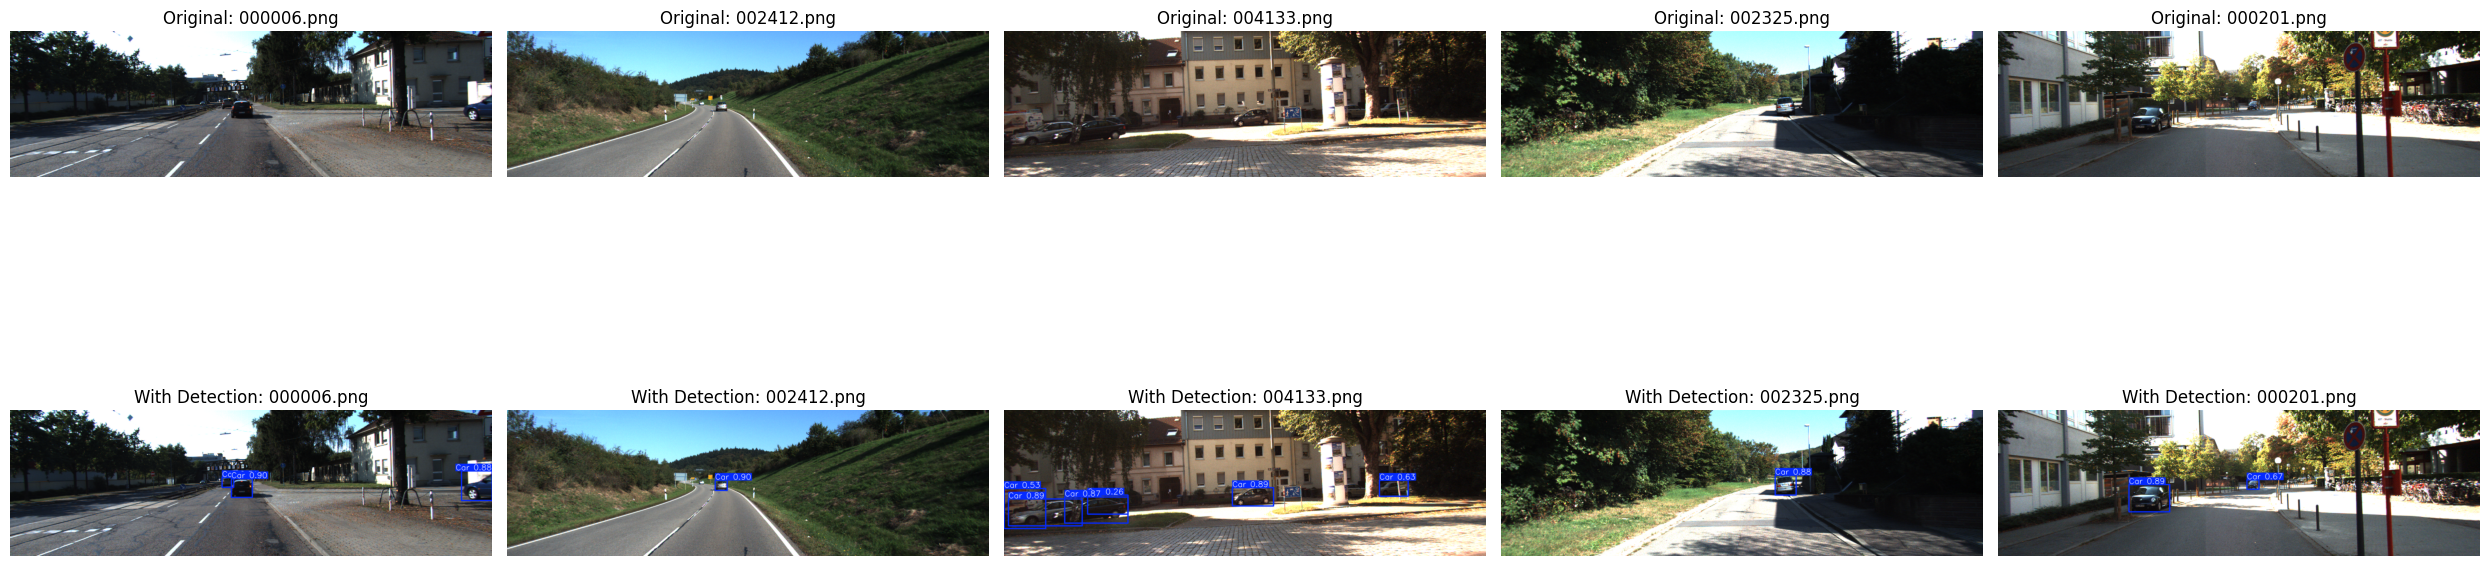

In [ ]:
test_images_dir = '/content/data_object_image_2/testing/image_2/'
results_dir = '/content/runs/detect/predict'

test_images = [
    "000006.png",
    "002412.png",
    "004133.png",
    "002325.png",
    "000201.png"
]

results_images = [
    "000006.png",
    "002412.png",
    "004133.png",
    "002325.png",
    "000201.png"
]

fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for i, (test_img_name, result_img_name) in enumerate(zip(test_images, results_images)):
    test_img_path = os.path.join(test_images_dir, test_img_name)
    test_img = cv2.imread(test_img_path)
    if test_img is not None:
        test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    result_img_path = os.path.join(results_dir, result_img_name)
    result_img = cv2.imread(result_img_path)
    if result_img is not None:
        result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    #  (before detection)
    axs[0, i].imshow(test_img)
    axs[0, i].axis('off')
    axs[0, i].set_title(f'Original: {test_img_name}')

    #  (after detection)
    axs[1, i].imshow(result_img)
    axs[1, i].axis('off')
    axs[1, i].set_title(f'With Detection: {result_img_name}')

plt.tight_layout()
plt.show()


Ground truth


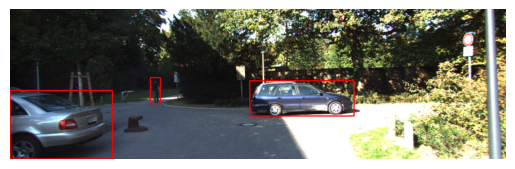

Predicted results

image 1/1 /content/valid/000208.png: 224x640 2 Cars, 1 Pedestrian, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.8ms postprocess per image at shape (1, 3, 224, 640)
Results saved to runs/detect/predict


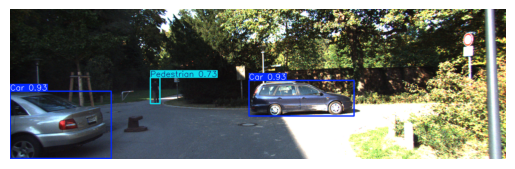

In [ ]:
print("Ground truth")
image_file = "/content/valid/000208.png"
label_file = "/content/valid/000208.txt"
show_image_with_bbox(image_file, label_file)
# ground truth
# -------------------------------------------
# predicted
print("Predicted results")

model.predict("/content/valid/000208.png",save=True)
predicted_image_path = '/content/runs/detect/predict/000208.png'


img = cv2.imread(predicted_image_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()


## Confusion Matrix

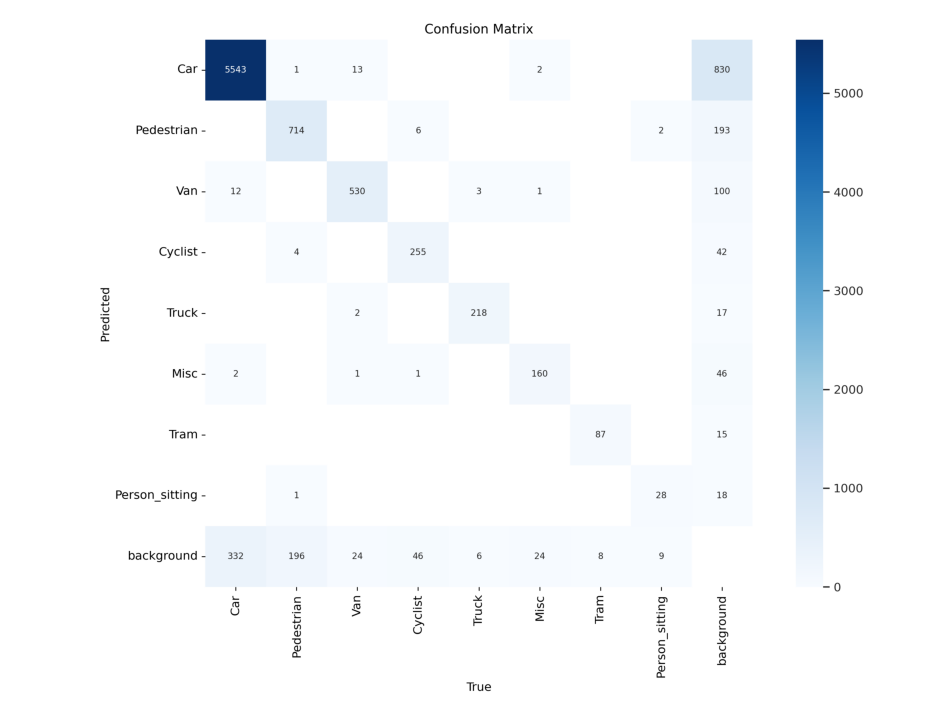

In [ ]:
img = plt.imread("/content/train/confusion_matrix.png")

plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.show()

## F1 curve

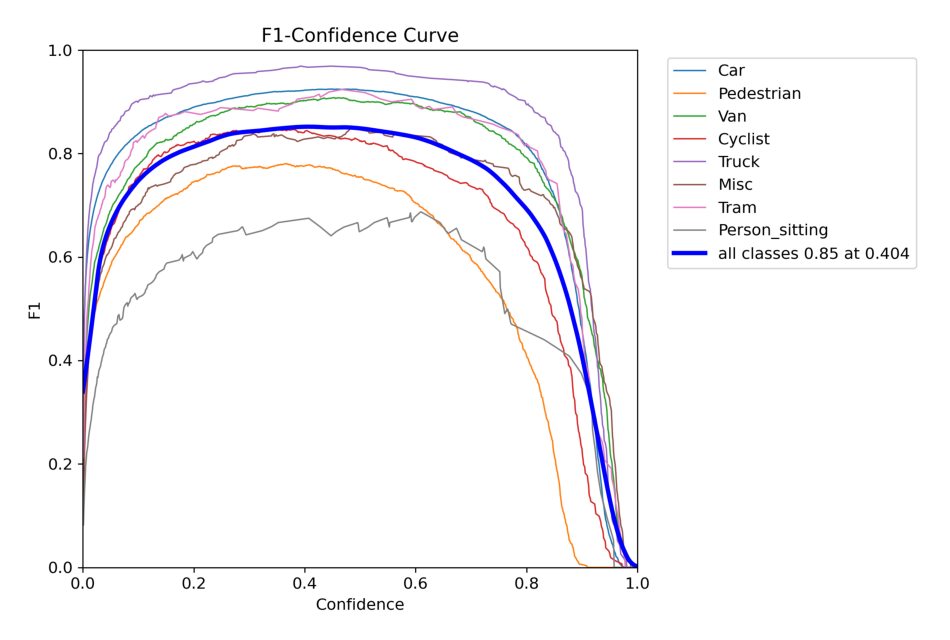

In [ ]:
img = plt.imread("/content/train/F1_curve.png")

plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.show()

##visualizing metrics

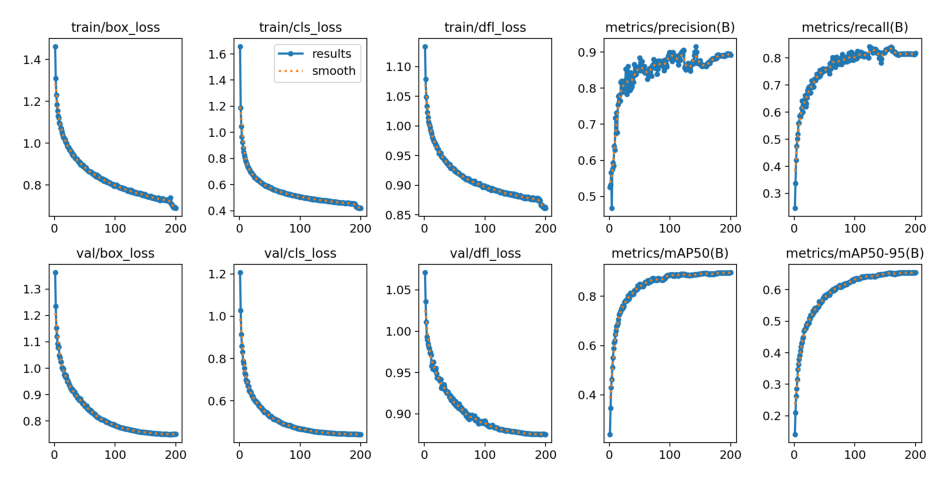

In [ ]:
img = plt.imread("/content/train/results.png")

plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.show()

The project used the YOLOv8 model to tackle object detection on the KITTI dataset, achieving strong performance metrics after training for 200 epochs. The model's output included bounding boxes, class labels, and confidence scores for detected objects such as cars, pedestrians, and cyclists, making it suitable for real-world autonomous driving applications. Key results showed an overall **recall** of **90**% and a **precision** of **81.3%**, with a mean average precision (mAP50) of **90**% and **mAP50-95** of **65.3%**. Class-specific performance indicated high accuracy for cars with a mAP50 of **96.4%** and cyclists at 88%, while lower precision was observed for pedestrians at 66%. Techniques such as hyperparameter tuning, data augmentation, and dropout helped optimize the model, resulting in strong detection rates across various object categories and real-world validation images. The model's ability to generalize well to unseen data ensures its practical use in enhancing autonomous driving safety.



Note: some of the preprocessing steps were taken from this [notebook](https://www.kaggle.com/code/varsha300/kitti-object-detection-yolov8n)